# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

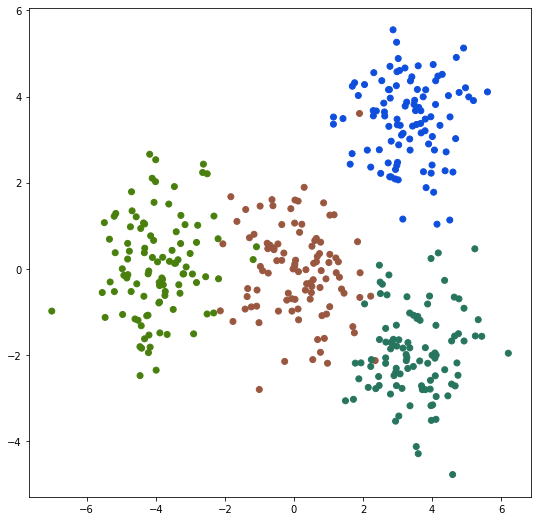

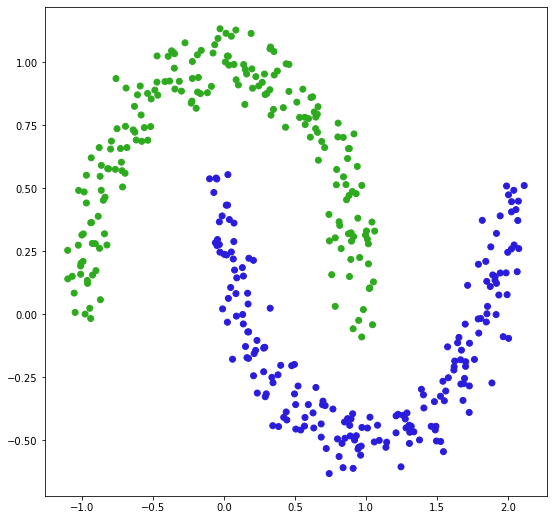

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        
        
    def _random_init(self):
        """
        Инициализация кластеров случайными точками.
        В качестве минимального и максимального значения 
        выберем минимальное и максимальное значение набора данных.
        """
        
        low = np.min(self.X)
        high = np.max(self.X)
        centroids = np.random.uniform(low, high, (self.n_clusters, self.m))
        return centroids
    
    
    def _sample_init(self):
        """
        Инициализация кластеров случаныйми точками из X.
        """
        
        rows = np.random.choice(self.n, self.n_clusters, replace=False)
        centroids = self.X[rows]
        return centroids
    
    
    def _k_means_init(self):
        """
        Инициализация с помощью алгоритма k-means++.
        """
        
        row = np.random.randint(self.n)
        centroids = self.X[row]
        min_distances = np.array([np.inf] * self.n)
        
        for _ in range(1, self.n_clusters):
            # Рассчет расстояния до нового центроида, обновление минимального расстояния при необходимости.
            new_distances = np.linalg.norm(self.X - centroids[-1], axis=1)
            min_distances = np.minimum(min_distances, new_distances)
            random = np.random.uniform(0, np.sum(min_distances ** 2))
            s, ind = 0, -1
                
            while s <= random: 
                ind += 1
                s += min_distances[ind] ** 2
                    
            centroids = np.vstack((centroids, self.X[ind]))
                    
        return centroids
        
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        n, _ = X.shape
        self.X = X
        self.n = n
                
        init = {
            'random': self._random_init,
            'sample': self._sample_init,
            'k-means++': self._k_means_init,
        }
        
        centroids = init[self.init]()
            
        distances = np.zeros((self.n, self.n_clusters))
        labels = np.zeros(self.n)
        
        for _ in range(self.max_iter):
            for cluster_ind in range(self.n_clusters):
                distances[:, cluster_ind] = np.linalg.norm(self.X - centroids[cluster_ind], axis=1)
                
            labels = np.argmin(distances, axis=1)
            
            for cluster_ind in range(self.n_clusters):
                current_cluster = self.X[labels == cluster_ind]

                if len(current_cluster) == 0:
                    random_point = np.random.randint(self.n)
                    labels[random_point] = cluster_ind

                centroids[cluster_ind] = np.mean(self.X[labels == cluster_ind], axis=0)
        
        self.centroids = centroids
        
    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        n, _ = X.shape
        distances = np.zeros((n, self.n_clusters))
        
        for cluster_ind in range(self.n_clusters):
            distances[:, cluster_ind] = np.linalg.norm(X - self.centroids[cluster_ind], axis=1)
            
        return np.argmin(distances, axis=1)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

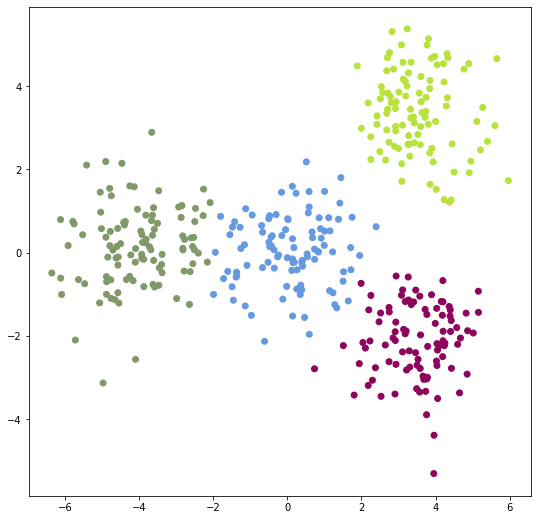

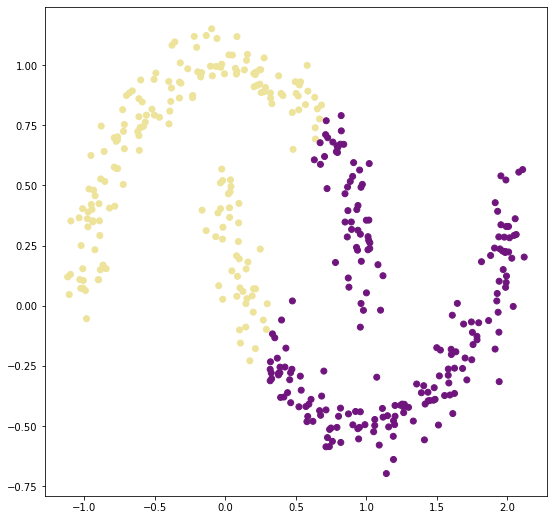

In [5]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='sample')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [6]:
from collections import deque

class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 3, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        n, _ = X.shape
        tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        # 0 -- Noise
        labels = np.array([-1] * n)
        queue = deque()
        current_label = 0
                
        for ind, x in enumerate(X):
            if labels[ind] != -1:
                continue
                
            neighbours_ind = tree.query_radius(x.reshape(1, -1), self.eps)[0]
            neighbours_ind = neighbours_ind[neighbours_ind != ind]
                
            if len(neighbours_ind) < self.min_samples:
                labels[ind] = 0
                continue
            
            # Нашли новый Core Sample
            current_label += 1
            labels[ind] = current_label
            queue.extend(neighbours_ind)
        
            while len(queue) > 0:
                current_ind = queue.popleft()
                if labels[current_ind] == 0:
                    labels[current_ind] = current_label
                
                if labels[current_ind] != -1:
                    continue
                    
                labels[current_ind] = current_label
                neighbours_ind = tree.query_radius(X[current_ind].reshape(1, -1), self.eps)[0]
                neighbours_ind = neighbours_ind[neighbours_ind != current_ind]
                
                if len(neighbours_ind) >= self.min_samples:
                    queue.extend(neighbours_ind)
                    
        # Если нет шума, то сдвинем на 1
        if len(labels[labels == 0]) == 0:
            labels -= 1
            
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

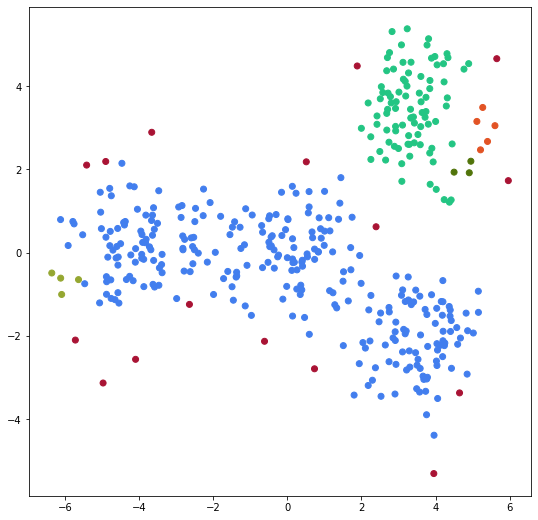

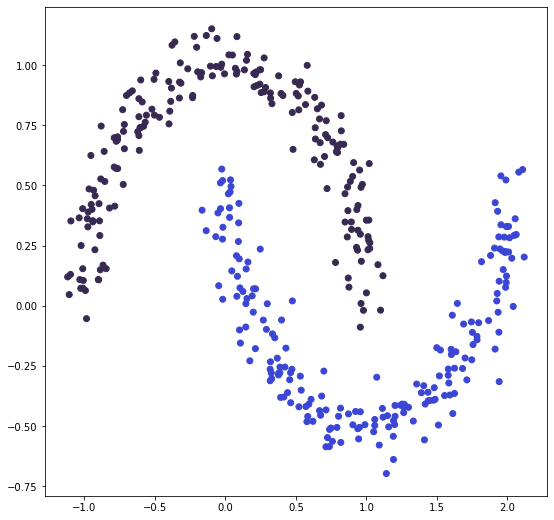

In [7]:
dbscan = DBScan(min_samples=3, eps=0.6)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(min_samples=3, eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [4]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage
        
    
    def _average_distance(self, X, cluster1, cluster2):
        s = 0
        
        for c1 in cluster1:
            for c2 in cluster2:
                s += np.linalg.norm(X[c1] - X[c2])
                
        return s / (len(cluster1) * len(cluster2))
    
    
    def _single_distance(self, X, cluster1, cluster2):
        s = np.inf
        for c1 in cluster1:
            for c2 in cluster2:
                s = np.minimum(s, np.linalg.norm(X[c1] - X[c2]))
                
        return s
    
    def _complete_distance(self, X, cluster1, cluster2):
        s = -1
        for c1 in cluster1:
            for c2 in cluster2:
                s = np.maximum(s, np.linalg.norm(X[c1] - X[c2]))
                
        return s
        
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        
        linkage = {
            'average': self._average_distance,
            'single': self._single_distance,
            'complete': self._complete_distance,
        }
        
        distance = linkage[self.linkage]
        n, _ = X.shape
        labels = np.arange(n)
        clusters = [[i] for i in range(n)]
        distances = np.zeros((n, n))
        updated_cluster, removed_cluster = None, None
        
        while len(clusters) != self.n_clusters:
            clusters_count = len(clusters)
            
            # Первая итерация, необходимо посчитать все расстояния
            if clusters_count == n:
                for ind1 in range(clusters_count):
                    for ind2 in range(ind1 + 1, clusters_count):
                        current_dist = distance(X, clusters[ind1], clusters[ind2])
                        distances[ind1][ind2] = current_dist
                        distances[ind2][ind1] = current_dist
                
                np.fill_diagonal(distances, np.inf)
            
            else:
                # Пересчет расстояний только для обновленного кластера
                distances = np.delete(distances, removed_cluster, 0)
                distances = np.delete(distances, removed_cluster, 1)
                
                for ind in range(clusters_count):
                    if ind != updated_cluster:
                        current_dist = distance(X, clusters[ind], clusters[updated_cluster])
                        distances[ind][updated_cluster] = current_dist
                        distances[updated_cluster][ind] = current_dist
                        
            
            min_distance_index = np.argmin(distances)
            updated_cluster = min_distance_index // clusters_count
            removed_cluster = min_distance_index % clusters_count     
            clusters[updated_cluster] += clusters[removed_cluster]
            labels[clusters[removed_cluster]] = updated_cluster
            del clusters[removed_cluster]
            labels[labels > removed_cluster] -= 1
    
        return labels


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

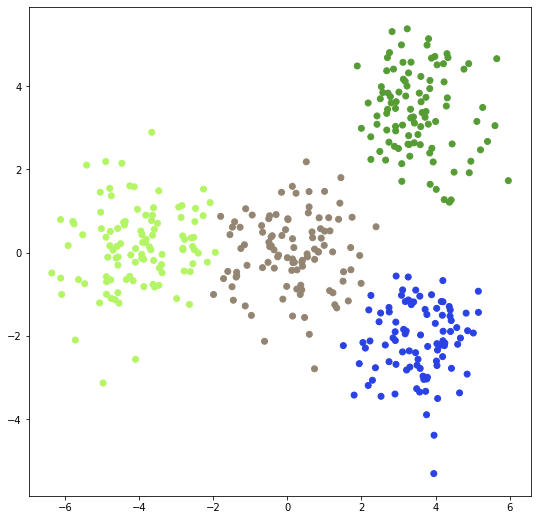

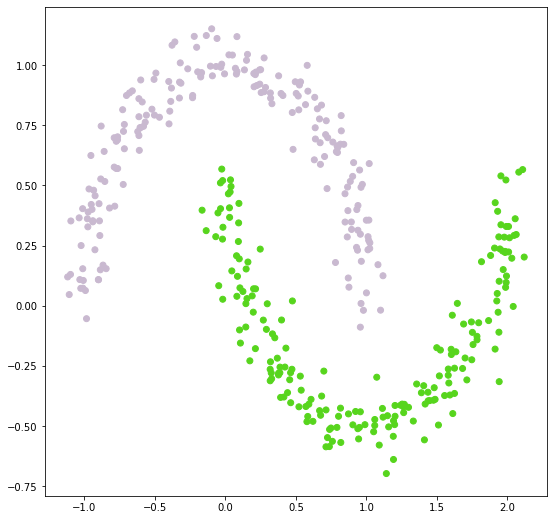

CPU times: user 42.9 s, sys: 223 ms, total: 43.1 s
Wall time: 43.2 s


In [9]:
%%time
# agg_clustering = AgglomertiveClustering(n_clusters=4)
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [10]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    
    image = cv2.imread(path)
    rgb_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_color
    
def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    brg_color = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, brg_color)

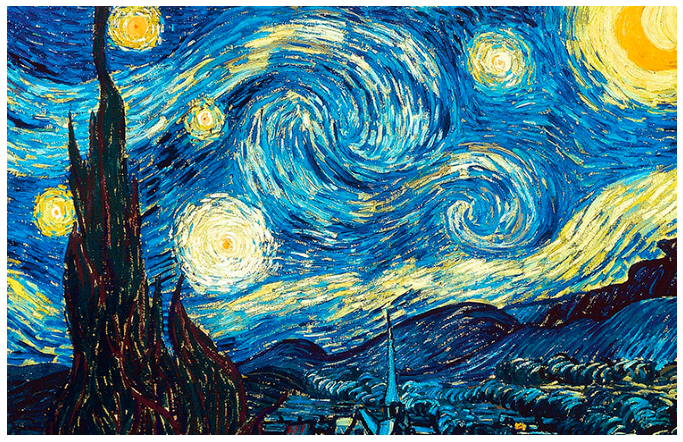

In [13]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [12]:
def clusterize_image(image, **kwargs):
    a, b, _ = image.shape
    flatten_image = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=16, init='k-means++', max_iter=90)
    kmeans.fit(flatten_image)

    cluster_colors = kmeans.centroids  # color of each cluster
    clusters = kmeans.predict(flatten_image) # Cluster labels for each pixel in flattened image
    recolored_func = lambda cluster: cluster_colors[cluster]
    recolored = recolored_func(clusters).reshape(a, b, 3) # Image with pixel colors assigned to corresponding cluster colors
    clusters_statistics(image.reshape(-1, 3) / 255, cluster_colors / 255, clusters) # Very slow (:
    return recolored

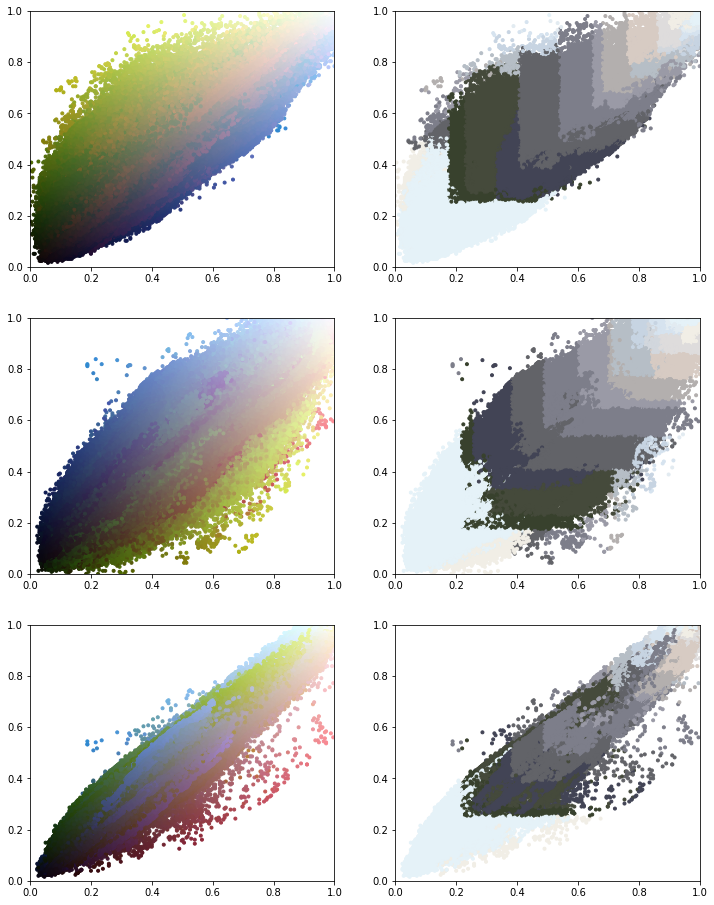

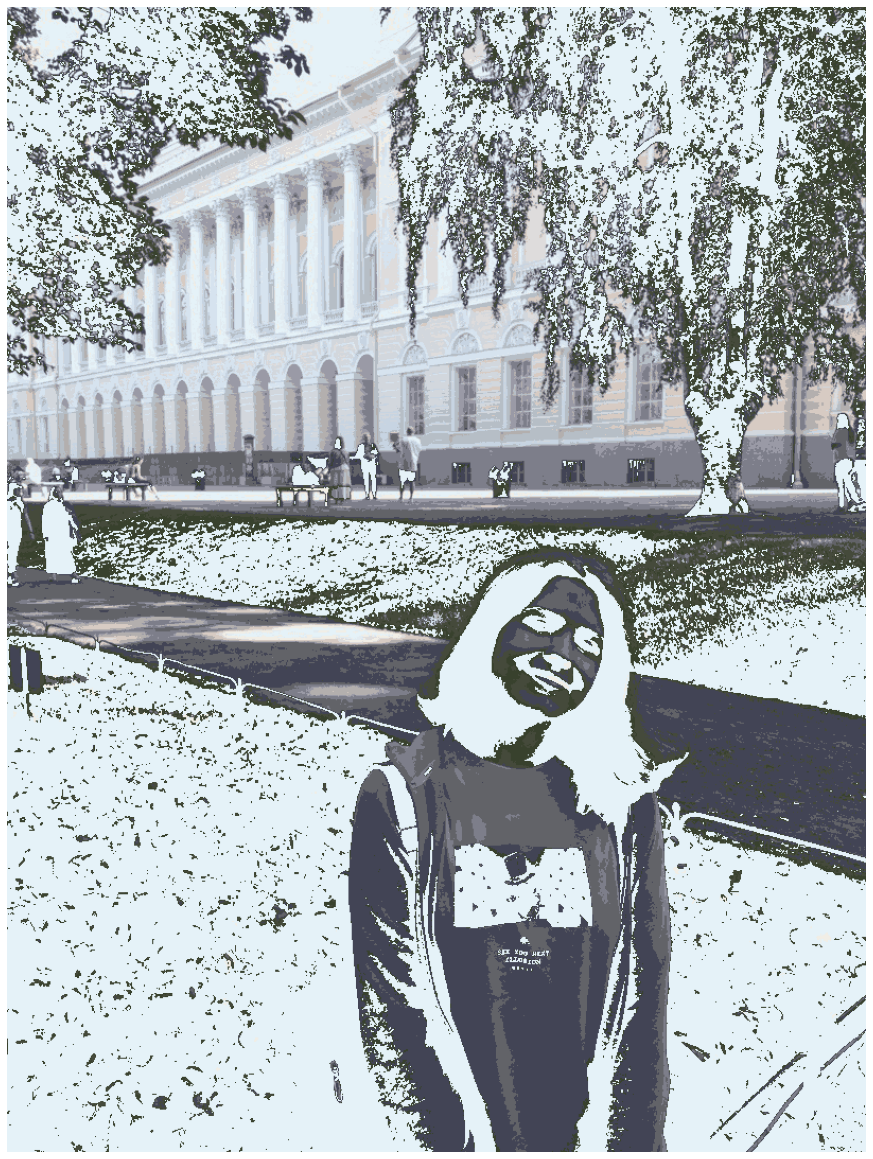

CPU times: user 3min 53s, sys: 20.8 s, total: 4min 14s
Wall time: 4min 13s


In [13]:
%%time
image = read_image("./katya.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "katya_result.jpg")

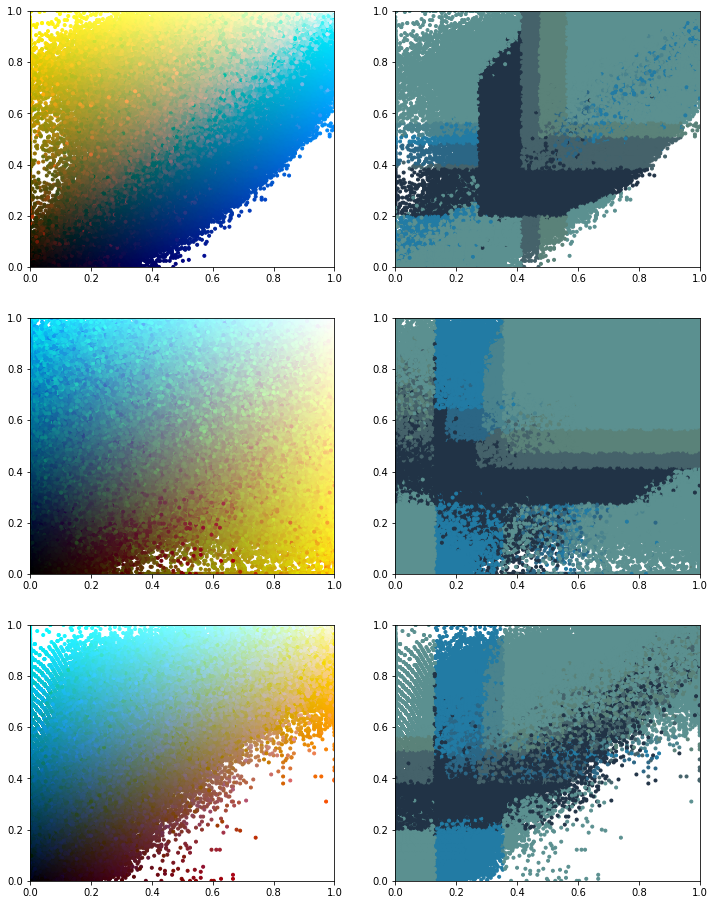

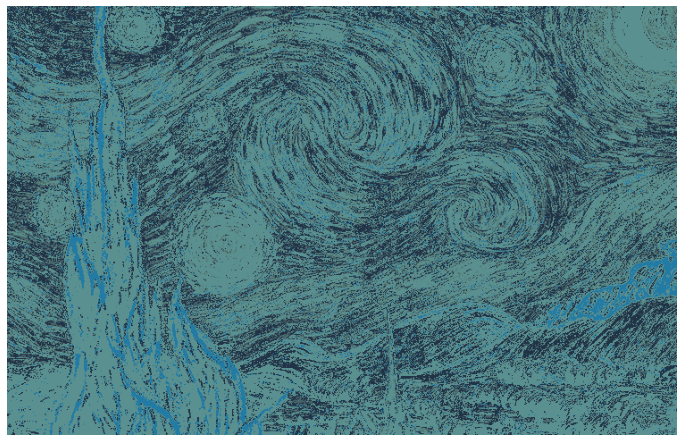

CPU times: user 59.9 s, sys: 4.46 s, total: 1min 4s
Wall time: 1min 3s


In [15]:
%%time
image = read_image("./image.png")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")